<a href="https://colab.research.google.com/github/VedantDesai11/LSTM_stock_price_predictor/blob/main/StockPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pydata/pandas-datareader.git

  Cloning https://github.com/pydata/pandas-datareader.git to /tmp/pip-req-build-c8_62qzo
  Running command git clone -q https://github.com/pydata/pandas-datareader.git /tmp/pip-req-build-c8_62qzo
  Created wheel for pandas-datareader: filename=pandas_datareader-0.11.0.dev0+4.gb1247d1-py3-none-any.whl size=109745 sha256=8cf0ea998dc1918af6b16827e1340b3f14a0436ec238ff55211afa61e1e304bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-dtqlqlif/wheels/54/6a/47/b1e68c4877ae6bf9a511e84e13972507e0fac9e17335156eb7
Successfully built pandas-datareader
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [2]:
import math
import datetime as dt
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [77]:
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2021,1,1)
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)

df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,27.860001,26.837500,27.847500,27.332500,212818400.0,24.819241
2015-01-05,27.162500,26.352501,27.072500,26.562500,257142000.0,24.120045
2015-01-06,26.857500,26.157499,26.635000,26.565001,263188400.0,24.122320
2015-01-07,27.049999,26.674999,26.799999,26.937500,160423600.0,24.460564
2015-01-08,28.037500,27.174999,27.307501,27.972500,237458000.0,25.400398
...,...,...,...,...,...,...
2020-12-24,133.460007,131.100006,131.320007,131.970001,54930100.0,131.549637
2020-12-28,137.339996,133.509995,133.990005,136.690002,124486200.0,136.254608
2020-12-29,138.789993,134.339996,138.050003,134.869995,121047300.0,134.440399


In [78]:
df.shape

(1511, 6)

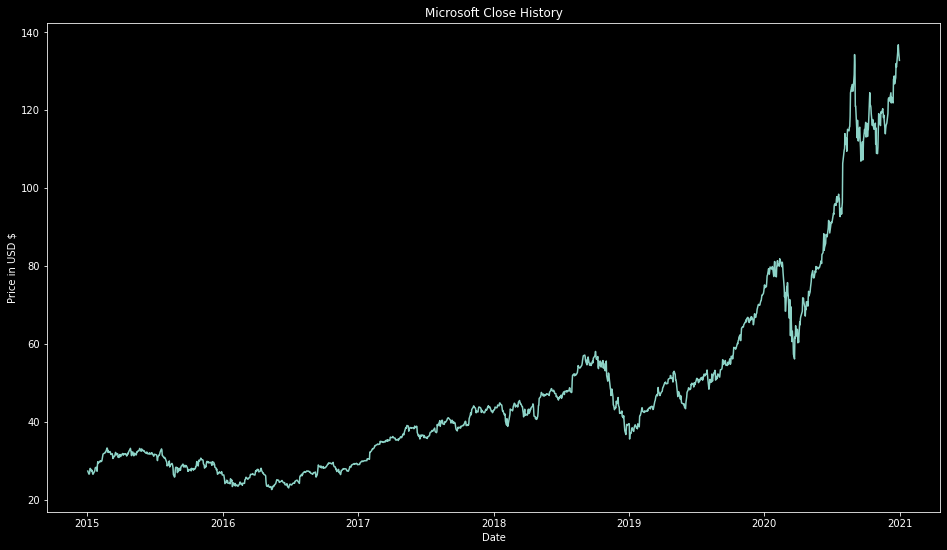

In [79]:
plt.figure(figsize=(16,9))
plt.title("Microsoft Close History")
plt.plot(df['Close'])

plt.xlabel('Date')
plt.ylabel('Price in USD $')
plt.show()

In [80]:
# new dataframe with only close data
data = df.filter(['Close'])

# convert dataframe to numpy array with just values
dataset = data.values

# get number of rows to train the model on
train_len = math.ceil(len(dataset) * 0.8)

train_len

1209

In [81]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

print(f'Min and Max values of scaled data: {float(min(scaled_data))}, {float(max(scaled_data))}')
print(f'Min and Max values of original data: {float(min(dataset))}, {float(max(dataset))}')

Min and Max values of scaled data: 0.0, 0.9999999999999999
Min and Max values of original data: 22.584999084472656, 136.69000244140625


In [82]:
# Create training dataset
# Create scaled training dataset
train_data = scaled_data[0:train_len,:]

# split data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [83]:
# Convert x_train and y_train to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape

(1149, 60)

In [84]:
# Reshape x_train data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(1149, 60, 1)

In [85]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [86]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [87]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1, validation_split=0.1)

1034/1034 [==============================] - 22s 19ms/step - loss: 0.0012 - val_loss: 2.2766e-04


In [88]:
# Create testing dataset
test_data = scaled_data[train_len - 60:,:]

# create x_test and y_test
x_test = []
y_test = dataset[train_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [89]:
# convert data to numpy array
x_test = np.array(x_test)
# reshape to 3D from 2D
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [90]:
# get models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [91]:
# get RMS error 
rms_error = np.sqrt(np.mean(predictions - y_test) ** 2)
rms_error

4.935152596985268

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


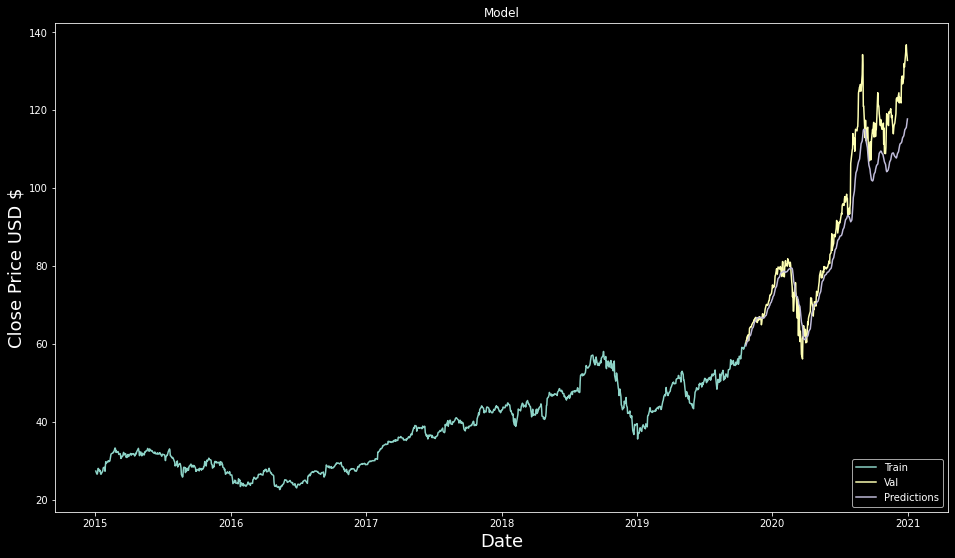

In [92]:
# Plot the data
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,9))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD $', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [93]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2019-10-22,59.990002,59.454273
2019-10-23,60.794998,59.765514
2019-10-24,60.895000,60.094604
2019-10-25,61.645000,60.423206
2019-10-28,62.262501,60.774780
...,...,...
2020-12-24,131.970001,114.888176
2020-12-28,136.690002,115.480392
2020-12-29,134.869995,116.266586


In [94]:
# Get the quote
apple_quote = web.DataReader('AAPL', 'yahoo', start_date, end='2021-01-05')

# Create a new df
new_df = apple_quote.filter(['Close'])

# Get the last 60 day closing price values and convert df to array
last_60_days = new_df[-60:].values

# Scale the data between 0 - 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = [last_60_days_scaled]

# Append last 60 days and convert to np.array
X_test = np.array(X_test)

# reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get predicted scaled price
pred_price = model.predict(X_test)

# Undo scaling
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)

[[118.263306]]


In [97]:
# Get the quote
apple_quote2 = web.DataReader('AAPL', 'yahoo', start='2021-01-06', end='2021-01-06')
print(apple_quote2['Close'], pred_price)

Date
2021-01-06    126.599998
Name: Close, dtype: float64 [[118.263306]]
